In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load MNIST digits
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)

In [3]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:


latent_dim = 10

def build_encoder():
    encoder_inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")



In [5]:
def build_decoder():
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    return tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [6]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
encoder = build_encoder()
decoder = build_decoder()
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=20, batch_size=128)

Epoch 1/20
469/469 [==============================] - 29s 59ms/step - loss: 259.7284 - reconstruction_loss: 209.3537 - kl_loss: 4.6906
Epoch 2/20
469/469 [==============================] - 23s 48ms/step - loss: 182.3850 - reconstruction_loss: 172.0643 - kl_loss: 7.0778
Epoch 3/20
469/469 [==============================] - 22s 48ms/step - loss: 171.7069 - reconstruction_loss: 159.2362 - kl_loss: 8.3345
Epoch 4/20
469/469 [==============================] - 21s 45ms/step - loss: 156.1927 - reconstruction_loss: 144.9557 - kl_loss: 9.4235
Epoch 5/20
469/469 [==============================] - 20s 43ms/step - loss: 150.3528 - reconstruction_loss: 140.7816 - kl_loss: 8.9060
Epoch 6/20
469/469 [==============================] - 20s 42ms/step - loss: 147.5827 - reconstruction_loss: 138.5936 - kl_loss: 8.6850
Epoch 7/20
469/469 [==============================] - 20s 42ms/step - loss: 146.0409 - reconstruction_loss: 137.0152 - kl_loss: 8.5915
Epoch 8/20
469/469 [==============================] - 2

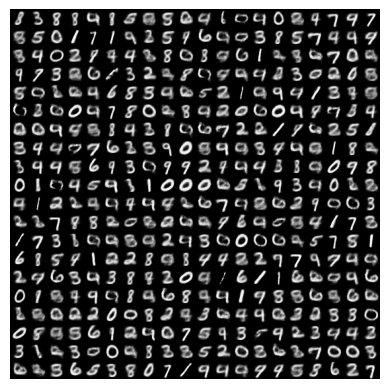

In [8]:
# Sample random points in the latent space
def plot_latent_space(decoder, n=10):
    # grid_x = np.linspace(-3, 3, n)
    # grid_y = np.linspace(-3, 3, n)[::-1]

    figure = np.zeros((28 * n, 28 * n))
    for i in range(n):
        for j in range(n):
            z_sample = np.random.randn(1,latent_dim)
            x_decoded = decoder.predict(z_sample,verbose=0)
            digit = x_decoded[0].reshape(28, 28)
            figure[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = digit

    # plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('off')
    plt.show()

plot_latent_space(decoder,n=20)